In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:
# Strong augmentation for underrepresented class duplicates
strong_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Standard transform for original images
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
class BalancedAugmentDataset(Dataset):
    def __init__(self, root_dir, transform_strong, transform_basic):
        self.root_dir = root_dir
        self.transform_strong = transform_strong
        self.transform_basic = transform_basic

        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}

        self.images_per_class = {cls: [] for cls in self.class_names}
        self.max_class_size = 0

        # Collect all image paths
        for cls in self.class_names:
            cls_dir = os.path.join(root_dir, cls)
            files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            self.images_per_class[cls].extend(files)
            self.max_class_size = max(self.max_class_size, len(files))

        # Balance the dataset
        self.balanced_data = []
        for cls in self.class_names:
            imgs = self.images_per_class[cls]
            needed = self.max_class_size - len(imgs)

            # Original images
            self.balanced_data.extend([(img_path, self.class_to_idx[cls], False) for img_path in imgs])

            # Duplicated + Augmented images
            if needed > 0:
                extra_imgs = random.choices(imgs, k=needed)
                self.balanced_data.extend([(img_path, self.class_to_idx[cls], True) for img_path in extra_imgs])

    def __len__(self):
        return len(self.balanced_data)

    def __getitem__(self, idx):
        img_path, label, should_augment = self.balanced_data[idx]
        image = Image.open(img_path).convert("RGB")

        if should_augment:
            image = self.transform_strong(image)
        else:
            image = self.transform_basic(image)

        return image, label

Dataset length: 96087


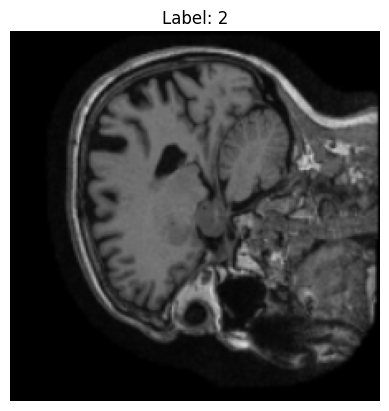

In [6]:
#  set data path
data_path = "./data"

# Create dataset using all classes inside this folder
train_dataset = BalancedAugmentDataset(
    root_dir=data_path,
    transform_strong=strong_augment,
    transform_basic=basic_transform
)

# Wrap in DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Quick check
print("Dataset length:", len(train_dataset))
img, label = train_dataset[67895]
plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

In [7]:
import os
from torchvision.utils import save_image
from tqdm import tqdm

# 🔁 Map class indices to names (order must match BalancedAugmentDataset)
idx_to_class = {
    0: "AD",
    1: "CN",
    2: "MCI"
}

# 📁 Destination folder
save_root = "./saved_augmented"

# 🚀 Create folders
for class_name in idx_to_class.values():
    os.makedirs(os.path.join(save_root, class_name), exist_ok=True)
print("egs",len(train_dataset))
# 💾 Save images
for i in tqdm(range(len(train_dataset))):
    img, label = train_dataset[i]  # img is a tensor
    class_name = idx_to_class[label]

    save_path = os.path.join(save_root, class_name, f"img_{i:05d}.jpg")
    
    # Denormalize if needed (assuming transforms.Normalize was used)
    denorm = img * 0.5 + 0.5
    save_image(denorm, save_path)

egs 96087


  0%|          | 0/96087 [00:00<?, ?it/s]

  4%|▍         | 3791/96087 [00:10<04:12, 366.16it/s]


KeyboardInterrupt: 

In [8]:
from collections import Counter

label_counts = Counter()
for _, label in train_dataset:
    label_counts[label] += 1

for k, v in label_counts.items():
    print(f"Class {k} count: {v}")

KeyboardInterrupt: 

In [9]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


In [10]:
from torchvision import transforms

# Define basic transform (for majority of samples)
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Define strong augmentations (for minority class balancing)
strong_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [11]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import DenseNet121_Weights
from tqdm import tqdm


# Use all CPU threads
torch.set_num_threads(os.cpu_count())

# Define model with new weights API
model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
model.classifier = torch.nn.Linear(model.classifier.in_features, 3)  # 3 classes
model = model.to(device)

# Make sure you import your dataset correctly (not from __main__)
from balanced_augment_dataset import BalancedAugmentDataset

train_dataset = BalancedAugmentDataset(
    root_dir="saved_augmented",
    transform_strong=strong_augment,
    transform_basic=basic_transform
)

# Training block inside __main__ to avoid multiprocessing issues
if __name__ == "__main__":
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=os.cpu_count(),  # parallel data loading
        pin_memory=False             # MPS doesn't support pinned memory
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()

    num_epochs = 3 

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    print("Training complete.")

Epoch 1/3: 100%|██████████| 3003/3003 [30:47<00:00,  1.63it/s]  


Epoch [1/3] - Loss: 0.3027


Epoch 2/3: 100%|██████████| 3003/3003 [37:36<00:00,  1.33it/s]


Epoch [2/3] - Loss: 0.0719


Epoch 3/3: 100%|██████████| 3003/3003 [3:45:48<00:00,  4.51s/it]     

Epoch [3/3] - Loss: 0.0442
Training complete.


In [14]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

val_dataset = ImageFolder(
    root="/Users/fatimatuzzahra/Downloads/processed_slices/val",
    transform=basic_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=False
)

In [15]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

idx_to_class = {
    0: 'AD',
    1: 'CN',
    2: 'MCI',
    # Add more if needed
}

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print results
print(classification_report(all_labels, all_preds, target_names=list(idx_to_class.values())))

              precision    recall  f1-score   support

          AD       0.73      0.79      0.76      1870
          CN       0.71      0.65      0.68      2585
         MCI       0.72      0.73      0.72      3960

    accuracy                           0.72      8415
   macro avg       0.72      0.72      0.72      8415
weighted avg       0.72      0.72      0.72      8415



In [16]:
print("Labels:", len(all_labels))
print("Predictions:", len(all_preds))


Labels: 8415
Predictions: 8415


Total predictions: 8415
Total labels: 8415
              precision    recall  f1-score   support

          AD       0.73      0.79      0.76      1870
          CN       0.71      0.65      0.68      2585
         MCI       0.72      0.73      0.72      3960

    accuracy                           0.72      8415
   macro avg       0.72      0.72      0.72      8415
weighted avg       0.72      0.72      0.72      8415



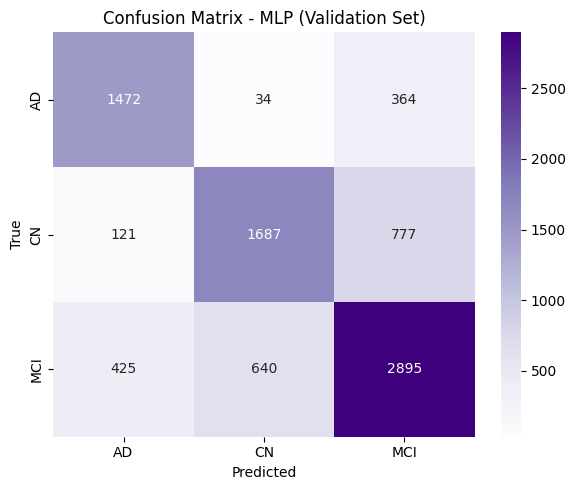

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
# Assuming model, val_loader, and device are already defined

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confirm something was collected
print("Total predictions:", len(all_preds))
print("Total labels:", len(all_labels))

# Your mapping
idx_to_class = {0: 'AD', 1: 'CN', 2: 'MCI'}

# Print report if predictions exist
if all_preds and all_labels:
    print(classification_report(all_labels, all_preds, target_names=list(idx_to_class.values())))
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - MLP (Validation Set)")
    plt.tight_layout()
    plt.show()
else:
    print("No predictions or labels found. Check the val_loader and model inference.")

